In [9]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.layers import Reshape, Conv2DTranspose, Activation, Conv2D, BatchNormalization, UpSampling2D, GaussianNoise, LeakyReLU, Dropout, AveragePooling2D, Flatten, Dense
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
MASK_DIR = 'dataset_200'
CHECKPOINT_DIR = 'dcgan/checkpoints'
IMAGE_SIZE = 256
BATCH_SIZE = 16

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [4]:
def get_generator():
    generator = tf.keras.Sequential([
        Reshape(target_shape=[1, 1, 4096], input_shape=[4096]),

        # 1x1x4096
        Conv2DTranspose(filters=256, kernel_size=4),
        Activation('relu'),

        # 4x4x256 - kernel sized increased by 1
        Conv2D(filters=256, kernel_size=4, padding='same'),
        BatchNormalization(momentum=0.7),
        Activation('relu'),
        UpSampling2D(),

        # 8x8x256 - kernel sized increased by 1
        Conv2D(filters=128, kernel_size=4, padding='same'),
        BatchNormalization(momentum=0.7),
        Activation('relu'),
        UpSampling2D(),

        # 16x16x128
        Conv2D(filters=64, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.7),
        Activation('relu'),
        UpSampling2D(),

        # 32x32x64
        Conv2D(filters=32, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.7),
        Activation('relu'),
        UpSampling2D(),

        # 64x64x32
        Conv2D(filters=16, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.7),
        Activation('relu'),
        UpSampling2D(),

        # 128x128x16
        Conv2D(filters=8, kernel_size=3, padding='same'),
        Activation('relu'),
        UpSampling2D(),

        # 256x256x8
        Conv2D(filters=1, kernel_size=3, padding='same'),
        Activation('sigmoid')
    ])
    return generator

In [5]:
def get_discriminator():
    discriminator = tf.keras.Sequential([
        # Gaussian noise helps to avoid overfitting
        GaussianNoise(0.2, input_shape=[256, 256, 1]),

        # 256x256x1 Image
        Conv2D(filters=8, kernel_size=3, padding='same'),
        LeakyReLU(0.2),
        Dropout(0.25),
        AveragePooling2D(),

        # 128x128x8
        Conv2D(filters=16, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.7),
        LeakyReLU(0.2),
        Dropout(0.25),
        AveragePooling2D(),

        # 64x64x16
        Conv2D(filters=32, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.7),
        LeakyReLU(0.2),
        Dropout(0.25),
        AveragePooling2D(),

        # 32x32x32
        Conv2D(filters=64, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.7),
        LeakyReLU(0.2),
        Dropout(0.25),
        AveragePooling2D(),

        # 16x16x64
        Conv2D(filters=128, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.7),
        LeakyReLU(0.2),
        Dropout(0.25),
        AveragePooling2D(),

        # 8x8x128
        Conv2D(filters=256, kernel_size=3, padding='same'),
        BatchNormalization(momentum=0.7),
        LeakyReLU(0.2),
        Dropout(0.25),
        AveragePooling2D(),

        # 4x4x256
        Flatten(),

        # 256
        Dense(128),
        LeakyReLU(0.2),

        Dense(1, activation='sigmoid')
    ])
    return discriminator

In [18]:
def binarize(mask):
    mask[mask > 0] = 1
    return mask

In [19]:
mask_generator = ImageDataGenerator(
    preprocessing_function=binarize
)

mask_generator = mask_generator.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=MASK_DIR,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode=None,
    seed=1,
    classes=['mask'],
    color_mode='grayscale',
)

train_masks = tf.data.Dataset.from_generator(
    generator=lambda: map(tuple, mask_generator),
    output_types=(tf.float32),
    output_shapes=[None, 256, 256, 1]
)


Found 200 images belonging to 1 classes.


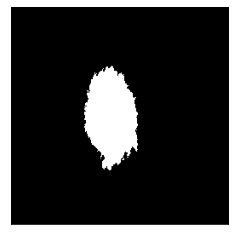

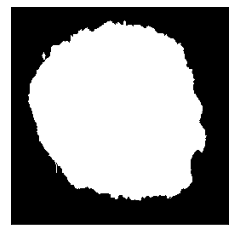

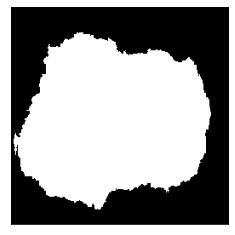

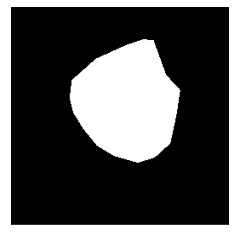

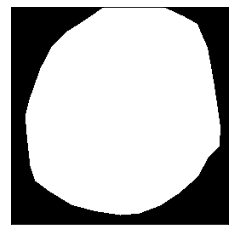

In [21]:
masks = next(mask_generator)

for m in list(masks)[:5]:
    fig = plt.imshow(m, cmap='gray')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [22]:
generator = get_generator()
discriminator = get_discriminator()

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)